# Projected correlation functions with CosmoSIS

The basic CosmoSIS pipeline in this repository will produce projected correlation functions for galaxy clustering $w_{gg}$, the galaxy density-intrinsic shear correlation $w_{g+}$, and the intrinsic shear auto-correlation $w_{++}$.

Models must be chosen for the computation of desired power spectra $P(k)$; here, we use halofit for the non-linear matter power, and we use the Non-Linear Alignment (NLA) model for the matter-intrinsic power $P_{\delta{}I}(k)$ and intrinsic auto-power $P_{II}(k)$.

Alternative choices might include models for baryonic contributions to the matter power, or more complex intrinsic alignment models, e.g. TATT, EFT, halo models, etc.

CosmoSIS implements no specific Hankel routine for the transformation of $P(k,z)$'s into $w(r_p,z)$'s, but we can use the Hankel transformers implemented for $C_\ell$'s. After running into SegFaults with nicaea, I have switched to another CosmoSIS default module: cl_to_corr.

The pipeline "Cosmosis_wgplus.ini" fully specifies the workflow, and contains comments describing the procedure - I recommend reading these before proceeding.

Let's generate a basic Smail-type redshift distribution $n(z)$ to demonstrate the pipeline:

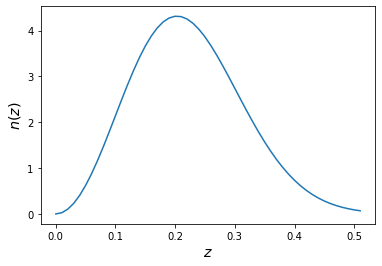

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# these choices will produce something vaguely GAMA-like
alpha = 2.
beta = 2.2
z0 = 0.3 / np.sqrt(2.)
z = np.linspace(0.0, 0.51, 52)
nz = z**alpha * np.exp(-(z/z0)**beta)
# normalise
nz /= np.trapz(nz, x=z)
# visualise
plt.plot(z, nz)
plt.xlabel('$z$', fontsize='x-large')
plt.ylabel('$n(z)$', fontsize='x-large')
# save as nofz.txt - to be read-in by CosmoSIS
np.savetxt('nofz.txt', np.column_stack((z, nz)), header='z\tbin_1')

We will use this $n(z)$ to describe all of our samples here, but a real analysis will likely employ several such distributions, each describing a sample of galaxies selected on quantities such as colour, magnitude, mass, etc. In those cases, labels for each sample ("nz_test" in this pipeline) must be carefully tracked, and some of the modules written for this notebook will need generalising. For now, let us run this simplified pipeline (can also be done from command line with "cosmosis Cosmosis_wgplus.ini"):

In [26]:
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from cosmosis.samplers.test.test_sampler import TestSampler
from cosmosis.output.in_memory_output import InMemoryOutput
ini = Inifile("CosmoSIS_wgplus.ini")
pipeline = LikelihoodPipeline(ini)
sampler = TestSampler(ini, pipeline, None)
sampler.config()
sampler.execute()

-- Setting up module consistency --

-- Setting up module camb --
 camb mode  =            1
 camb cmb_lmax =         2500
 camb FeedbackLevel =            2
 accuracy boost =    1.0000000000000000     
 HighAccuracyDefault =  F

-- Setting up module halofit --

-- Setting up module nonlinear_linear_alignment --

-- Setting up module ia_z_powerlaw --

-- Setting up module constant_bias --

-- Setting up module load_nz --
Found 1 samples and 52 bins in redshift in file /Users/Harry/2ptPipeline/ECHOIA/IAmodeling/notebooks/cosmosis_wgplus/nofz.txt

-- Setting up module coerce_gg --

-- Setting up module coerce_gI --

-- Setting up module coerce_II --

-- Setting up module project_gg --

-- Setting up module project_gI --

-- Setting up module project_II --

-- Setting up module collect_wgg --

-- Setting up module collect_wgp --

-- Setting up module collect_wpp --

Setup all pipeline modules
Module timing:
consistency 0.001823
camb 0.002822
halofit 0.001976
nonlinear_linear_alignment 0.0

/Users/Harry/2ptPipeline/ECHOIA/IAmodeling/notebooks/cosmosis_wgplus/projected_alignments.py:37: RuntimeWarning: invalid value encountered in true_divide
  Wz_nom = np.nan_to_num((pz_1 * pz_2) / (Xz2 * Xprime))


See from the stdout that the runtimes for 'project' modules (the Hankel pieces) are ~30ms for $w_{gg}$ and $w_{g+}$, and twice that for $w_{++}$ which requires two calls (the sum of the $J_0$ and $J_4$ Hankel integrations, see Singh et al. 2016).

Should now have a subdirectory called 'datablock', which contains power spectra, distances, parameter values, redshift distributions, and derived quantities, such as our projected correlation functions.

In [27]:
import os
ls = os.listdir('datablock')
ls.sort()
print(ls)

['cmb_cl', 'cosmological_parameters', 'distances', 'galaxy_bias', 'galaxy_intrinsic_power', 'galaxy_power', 'intrinsic_alignment_parameters', 'intrinsic_power', 'linear_cdm_transfer', 'matter_galaxy_power', 'matter_intrinsic_power', 'matter_power_lin', 'matter_power_nl', 'nz_test', 'projected_galaxy_intrinsic', 'projected_galaxy_power', 'projected_intrinsic']


Now let's take a look at the theoretical curves, and compare them to KiDS+GAMA measurements of projected statistics (presented in Johnston et al., 2019). Note that we are using a toy $n(z)$, and ignoring the integral constraint for galaxy clustering, so we do not expect a perfect reproduction. Since we ran with unit galaxy bias $b_g$ and NLA amplitude $A_{IA}$ (see values.ini file) we will re-scale the theory spectra by the best fit parameters from Johnston et al. (2019), who fitted to scales $r_p>6\;{\rm{Mpc}}/h$.

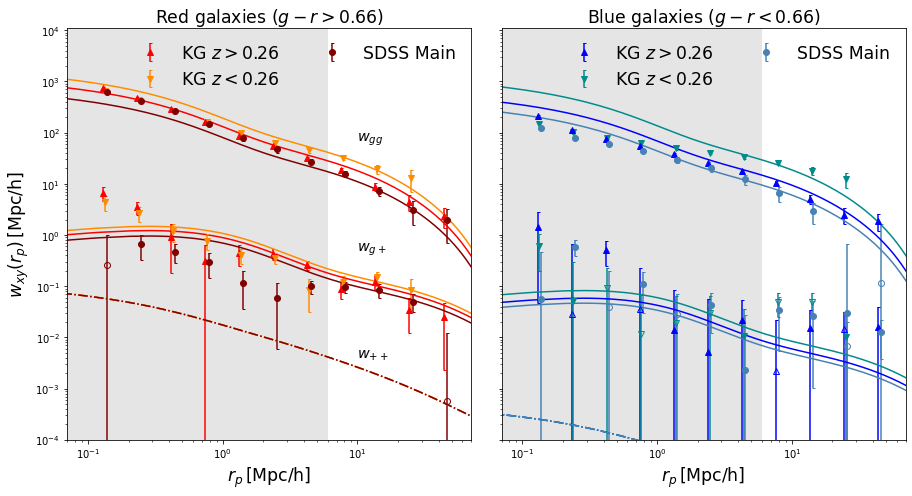

In [28]:
from os.path import join
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13, 7))
plt.yscale('log')
plt.xscale('log')
rp =  np.loadtxt('datablock/projected_galaxy_intrinsic/theta.txt')
wgg = np.loadtxt('datablock/projected_galaxy_power/wgg_r_1_1.txt')
wgp = np.loadtxt('datablock/projected_galaxy_intrinsic/wgp_r_1_1.txt')
wpp = np.loadtxt('datablock/projected_intrinsic/wpp_r_1_1.txt')
# wg+ is negative by GGL convention, but we tend to measure radial alignments as positive
wgp = -wgp
# mark the non-linear regime where Johnston et al., 2019 did not fit their models
for a in ax:
    a.axvspan(1e-2, 6., color='grey', alpha=0.2, lw=0)

# let's plot the measured data-points for KiDS+GAMA & SDSS Main samples,
# split by redshift and/or galaxy colour
# colours/labels/horizontal offsets, for clarity
keys  =                ['z2_b','z2_r','z1_b','z1_r','sdss_b','sdss_r']
names = dict(zip(keys, ['KG $z>0.26$','KG $z>0.26$','KG $z<0.26$','KG $z<0.26$','SDSS Main','SDSS Main']))
cols  = dict(zip(keys, ['blue','red','darkcyan','darkorange','steelblue','maroon']))
marks = dict(zip(keys, ['^','^','v','v','o','o']))
split = dict(zip(keys, [0.97,0.97,1.,1.,1.03,1.03]))
bias  = dict(zip(keys, [1.10,1.52,1.55,1.84,0.88,1.19]))
aia   = dict(zip(keys, [0.21,3.18,0.21,3.18,0.21,3.18]))

cosmosis_curves = {}
for df in os.listdir('J19_measurements'):
    _r, _w, _e = np.loadtxt(join('J19_measurements', df)).T
    name = df.replace('wgp_','').replace('wgg_','')
    if   name.endswith('_r'): a = ax[0]
    elif name.endswith('_b'): a = ax[1]

    # scale theory correlation functions
    if 'wgg' in df:
        th_w  = wgg * bias[name]**2.
        label = None
    elif 'wgp' in df:
        th_w   = wgp * aia[name] * bias[name]
        th_wpp = wpp * aia[name]**2.
        label  = names[name]
        
    # discard largest-r_p bin for low-z GAMA (see Johnston et al., 2019)
    if 'z1' in df:
        _r, _w, _e = map(lambda x: x[:-1], (_r, _w, _e))

    # plot measurements, with open points for negative values
    c = _w > 0.
    eb = a.errorbar(_r[c]*split[name], _w[c], _e[c],
                    ls='', marker=marks[name], c=cols[name],
                    label=label, capsize=1.5)
    if any(_w < 0.):
        a.errorbar(_r[~c]*split[name], -_w[~c], _e[~c],
                   ls='', marker=marks[name], c=cols[name],
                   label=None, capsize=1.5, mfc='none')

    # plot theory curves
    a.plot(rp, th_w, c=eb[0].get_c())
    cosmosis_curves[df] = th_w # store for comparisons
    # also plot expected w++ for completeness, though low S/N
    # means that we have no measurements to compare with
    if 'wgp' in df:
        a.plot(rp, th_wpp, c=eb[0].get_c(), ls='-.')
        cosmosis_curves[df+'wpp'] = th_wpp # store for comparisons

for lab, a in zip(('Red galaxies ($g-r>0.66$)', 'Blue galaxies ($g-r<0.66$)'), ax):
    a.set_title(lab, fontsize='xx-large')
    l = a.legend(loc='best', ncol=2, frameon=0, fontsize='xx-large')
    a.set_xlabel('$r_p\,[\\rm{Mpc/h}]$', fontsize='xx-large')
ax[0].set_ylabel('$w_{xy}(r_p)\,[\\rm{Mpc/h}]$', fontsize='xx-large')
ax[0].annotate('$w_{gg}$', xy=(10,70), xycoords='data', fontsize='x-large')
ax[0].annotate('$w_{g+}$', xy=(10,0.5), xycoords='data', fontsize='x-large')
ax[0].annotate('$w_{++}$', xy=(10,0.004), xycoords='data', fontsize='x-large')
plt.xlim(0.07, 70)
plt.ylim(1e-4, None)
plt.tight_layout()

One sees that the theoretical curves produced here are very close to the published, no-shortcuts versions. We can also do the Hankel transformation with CCL. Let's use the same $P(k)$'s and compare:

In [29]:
# we need to extrapolate onto a wider wavevector range for the integration
# (in CosmoSIS, this is done internally)
_k = np.loadtxt('datablock/galaxy_power/k_h.txt')
kmin, kmax = _k.min(), _k.max()
k = np.logspace(-5, 3, 80)

# load 3D power spectra
pk_z = np.loadtxt('datablock/galaxy_power/z.txt')
Pgg = np.loadtxt('datablock/galaxy_power/p_k.txt')
PgI = np.loadtxt('datablock/galaxy_intrinsic_power/p_k.txt')
PII = np.loadtxt('datablock/intrinsic_power/p_k.txt')
# also load the redshift window function W(z) generated by CosmoSIS helper module projected_alignments.py
# W(z) depends only on redshift distributions; see Mandelbaum et al. 2011 for equations
z = np.loadtxt('datablock/projected_galaxy_power/z.txt')
Wz = np.loadtxt('datablock/projected_galaxy_power/w_z.txt')
# also load and cut-down the r_p range for the output
# r_p = np.loadtxt('datablock/projected_galaxy_power/r_p.txt')
# r_p = r_p[(r_p > 0.05) & (r_p < 100.)]
r_p = np.logspace(-5, 8, 130)

# interpolate P(k)'s onto same redshifts as n(z)
from scipy.interpolate import interp2d
_Pgg = interp2d(_k, pk_z, Pgg, kind='cubic', bounds_error=False)(k, z)
_PgI = interp2d(_k, pk_z, PgI, kind='cubic', bounds_error=False)(k, z)
_PII = interp2d(_k, pk_z, PII, kind='cubic', bounds_error=False)(k, z)

# we have NaNs outside the integration range; replace with simple
# power law extrapolations, as done internally by CosmoSIS transformer module
lower = 1.
upper = -2.
def extrapolate(P):
    bad_low = np.isnan(P) & (k < kmin)
    bad_high = np.isnan(P) & (k > kmax)
    _P = P.copy()
    _P[bad_low] = P[0] * (k[bad_low] / kmin)**lower
    _P[bad_high] = P[-1] * (k[bad_high] / kmax)**upper
    return _P
_Pgg = np.array([extrapolate(pk) for pk in _Pgg])
_PgI = np.array([extrapolate(pk) for pk in _PgI])
_PII = np.array([extrapolate(pk) for pk in _PII])

import pyccl as ccl
# initialise a Cosmology object, with the same parameters as the CosmoSIS pipeline
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s=2e-9, n_s=0.96, m_nu=0.06,
                      matter_power_spectrum='halofit')

In [30]:
%%time
# Hankel transform for w_xy(r, z)
method = 'fftlog'
w_gg_rz = np.array([ccl.correlation(cosmo, k, pk, r_p, type='NN', method=method) for pk in _Pgg])
w_gp_rz = np.array([ccl.correlation(cosmo, k, pk, r_p, type='NG', method=method) for pk in _PgI])
w_pp_rz = np.array([ccl.correlation(cosmo, k, pk, r_p, type='GG+', method=method) \
                  + ccl.correlation(cosmo, k, pk, r_p, type='GG-', method=method) for pk in _PII])
# and integrate (Riemann sum) over the redshift window function for projected statistics
dz = z[1] - z[0]
wgg = (w_gg_rz.T * Wz * dz).sum(axis=-1)
wgp = (w_gp_rz.T * Wz * dz).sum(axis=-1)
wpp = (w_pp_rz.T * Wz * dz).sum(axis=-1)

CPU times: user 167 ms, sys: 3.15 ms, total: 170 ms
Wall time: 169 ms


Out of the box speed is of similar order to CosmoSIS for FFTLog integration method - may be room for tuning of this/CosmoSIS via accuracy settings etc. Let's take a look at the difference between these and the CosmoSIS outputs (note that the Hankel transformer is the only real variable here, as we loaded the CosmoSIS power spectra for projection):

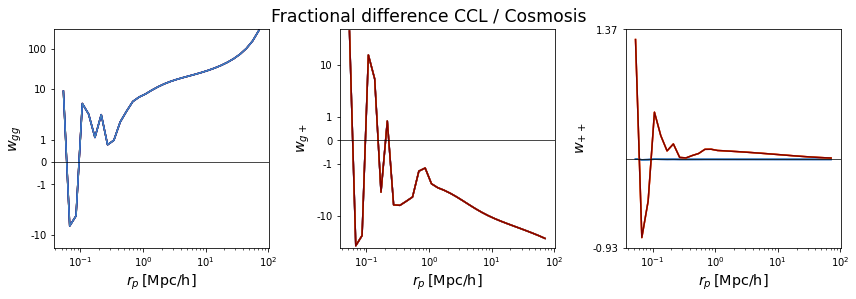

In [31]:
from scipy.interpolate import interp1d
from matplotlib.ticker import FuncFormatter


def compare_CosmoSIS_and_CCL(r_p, wgg, wgp, wpp):
    f1, ax1 = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(12,4))
    ax1[0].set_xscale('log')
    c = (r_p > 0.05) & (r_p < 80)
    for df in os.listdir('J19_measurements'):
        name = df.replace('wgp_','').replace('wgg_','')
        # scale theory correlation functions
        if 'wgg' in df:
            th_w  = wgg * bias[name]**2.
            label = None
            a = ax1[0]
        elif 'wgp' in df:
            th_w   = wgp * aia[name] * bias[name]
            th_wpp = wpp * aia[name]**2.
            label  = names[name]
            a = ax1[1]

        # compare with CosmoSIS version
        th_w_cosmosis = interp1d(rp, cosmosis_curves[df],
                                 kind='cubic', bounds_error=False, fill_value=np.nan)(r_p)
        ratio = th_w / th_w_cosmosis - 1.
        a.plot(r_p[c], ratio[c], c=cols[name], label=label)
        if 'wgp' in df:
            th_wpp_cosmosis = interp1d(rp, cosmosis_curves[df+'wpp'],
                                      kind='cubic', bounds_error=False, fill_value=np.nan)(r_p)
            ratio1 = th_wpp / th_wpp_cosmosis - 1.
            ax1[2].plot(r_p[c], th_wpp[c], c=cols[name])


    f1.text(0.5, 0.995, 'Fractional difference CCL / Cosmosis',
            fontsize='xx-large', ha='center', va='center')
    ax1[0].set_ylabel('$w_{gg}$', fontsize='x-large')
    ax1[1].set_ylabel('$w_{g+}$', fontsize='x-large')
    ax1[2].set_ylabel('$w_{++}$', fontsize='x-large')
    for a in ax1:
        a.axhline(0, c='k', lw=0.7)
        a.set_yscale('symlog')
        a.set_xlabel('$r_p\,[\\rm{Mpc/h}]$', fontsize='x-large')
        yticks = a.get_yticks()
        a.set_yticks(np.round(yticks,2))
        formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
        a.yaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.show()
compare_CosmoSIS_and_CCL(r_p, wgg, wgp, wpp)

We have clear ringing and aliasing affecting the Hankel integtrations - this can usually be addressed by choosing appropriate windows in $k$ over which to integrate, and/or modifying the input $P(k)$ so that it plays more nicely with CCL's FFTLog (fast) implementation.

Christos Georgiou kindly found some time to tackle this problem in CCL, with an edit to the CCL/pyccl/correlations.py file (branch not yet merged). Let's implement his new functionality below, naively plugging in our previous variables.

In [32]:
# copy some variables
a_sample = 1. / (1. + z[::-1]) # reverse order so that a increases monotonically
k_sample = k
z_arr = z
pz = nz
pk_GI_NLA = _PgI[::-1] # also reverse for P(k)'s
pk_II_NLA = _PII[::-1]
pk_gg = _Pgg[::-1]
pk2d_GI_NLA = ccl.pk2d.Pk2D(a_arr=a_sample, lk_arr=np.log(k_sample), pk_arr=pk_GI_NLA, is_logp=False)
pk2d_II_NLA = ccl.pk2d.Pk2D(a_arr=a_sample, lk_arr=np.log(k_sample), pk_arr=pk_II_NLA, is_logp=False)
pk2d_gg = ccl.pk2d.Pk2D(a_arr=a_sample, lk_arr=np.log(k_sample), pk_arr=pk_gg, is_logp=False)

In [33]:
# test some array shapes
wgg_ccl = cosmo.correlation_ab(1., z_arr, pz, p_of_k_a=pk2d_gg, type='gg')
print(wgg_ccl)
wgg_ccl = cosmo.correlation_ab(np.array([1]), z_arr, pz, p_of_k_a=pk2d_gg, type='gg')
print(wgg_ccl)
wgg_ccl = cosmo.correlation_ab(np.array([1,2]), z_arr, pz, p_of_k_a=pk2d_gg, type='gg')
print(wgg_ccl)

58.3071998424239
[58.30719984]
[52.42085555 28.61766179]


/Users/Harry/6x2pt/CCL/pyccl/correlations.py:474: UserWarning: Step size causes scale factor > 1. Using step=0.005000
  warnings.warn('Step size causes scale factor > 1. Using step=%f'
/Users/Harry/6x2pt/CCL/pyccl/correlations.py:379: RuntimeWarning: invalid value encountered in true_divide
  wz = dndz*dndz2*(1+z)**2/(
/Users/Harry/6x2pt/CCL/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


In [34]:
%%time
# and now compute the projected correlations
wgg_new = cosmo.correlation_ab(r_p, z_arr, pz, p_of_k_a=pk2d_gg, type='gg')
wgp_new = cosmo.correlation_ab(r_p, z_arr, pz, p_of_k_a=pk2d_GI_NLA, type='g+')
wpp_new = cosmo.correlation_ab(r_p, z_arr, pz, p_of_k_a=pk2d_II_NLA, type='++')

CPU times: user 113 ms, sys: 1.65 ms, total: 114 ms
Wall time: 114 ms


Runtime is almost identical to CosmoSIS -- let's see how the results compare with the CosmoSIS outputs.

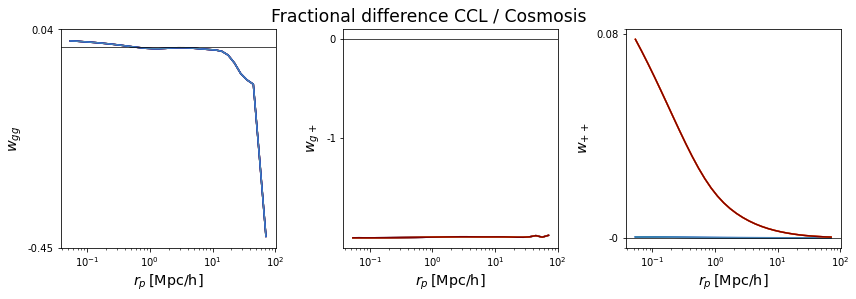

In [35]:
# and now the moment of truth...
compare_CosmoSIS_and_CCL(r_p, wgg_new, wgp_new, wpp_new)

Nearly there! Some residual disagreements to investigate in the coming weeks.

I can be reached at h.s.johnston@uu.nl for any questions regarding the example CosmoSIS pipeline, or for suggestions to improve this notebook.

If making use of this notebook, modules, etc., please consider citing arXiv:1811.09598.